In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd

from models.encoder_model import SpecialTransformer
from utils.visualization import plot_attention_heatmap, context_analysis
from utils.context_encoding import ContextEncoder
from utils.preprocessing import *

### Dataset Preparation

In [2]:
df = pd.read_csv(r"./dataset/dataset.csv")
df.head()

,Scalar_B,BX_GSE,BY_GSM,BZ_GSM,SW_Temp,SW_Density,SW_Speed,Flow_Pressure,E_Field,Dst,time
0,7.8,-5.6,3.2,-4.0,76351.0,5.4,389.0,1.54,1.56,6,1640995200
1,8.3,-5.3,4.9,0.4,67379.0,4.7,390.0,1.26,-0.16,-3,1640998800
2,9.3,-2.7,3.9,-4.1,103254.0,2.1,454.0,0.87,1.86,-7,1641002400
3,9.8,1.7,4.0,-8.4,194757.0,2.7,466.0,1.17,3.91,-13,1641006000
4,8.5,-3.0,4.6,-4.4,126079.0,1.9,454.0,0.70,2.00,-21,1641009600


In [3]:
feature_cols = ['Scalar_B', 'BX_GSE', 'BY_GSM', 'BZ_GSM', 'SW_Temp', 'SW_Density', 'SW_Speed', 'Flow_Pressure', 'E_Field']
target_col = 'Dst'
context_cols = ['time']
numerical_features_info = {k:"standard" for k in feature_cols}

dataset = TabularDataset(
    data_path=r"./dataset/dataset.csv",
    feature_cols=feature_cols,
    target_col=target_col,
    context_cols=context_cols,
    numerical_features_info=numerical_features_info
)

In [4]:
batch_size = 32
num_features = len(feature_cols)

In [5]:
train_dataset, val_dataset, test_dataset = split_data(dataset)
train_loader = create_dataloader(train_dataset, batch_size=batch_size)
val_loader = create_dataloader(val_dataset)
test_loader = create_dataloader(test_dataset)

### Define Important Module

In [6]:
config_path = r"./config.json"
context_cols = {"time": "time"}
embedding = ContextEncoder(context_cols, config_path)
model = SpecialTransformer(config_path)

In [7]:
sample = next(iter(train_loader))

features = sample['features'].unsqueeze_(dim=-1)

input_context = torch.tensor(np.array([v.cpu().numpy() for k, v in sample['context'].items()]))
context_embedding = embedding(input_context, 'cpu')

print("Input Matrix")
print("-"*20)
print(features.size())
print(context_embedding.size())
print("-"*20)
 
outputs = model(features, context_embedding)

print(outputs.size())

Input Matrix
--------------------
torch.Size([32, 9, 1])
torch.Size([32, 5, 128])
--------------------
torch.Size([32, 1])


### Create the training loop

In [8]:
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
embedding = embedding.to(device)

print(device)

cuda


In [9]:
from tqdm import tqdm

In [10]:
num_epochs = 20
best_val_loss = float('inf')
patience = 5  # Early stopping patience
epochs_no_improve = 0
train_losses = []  # Store training losses
val_losses = []    # Store validation losses
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    embedding.train()
    running_loss = 0.0
    for batches in train_loader:
        # Move data to the device
        features = batches["features"].to(device)
        targets = batches["target"].to(device)
        input_context = torch.tensor(np.array([v.cpu().numpy() for k, v in batches["context"].items()]))
        input_context = input_context.to(device)
        context = embedding(input_context, device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(features.unsqueeze_(dim=-1), context)
        
        # Calculate the loss
        loss = criterion(outputs.squeeze(), targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)  # Accumulate loss for the epoch
        
    epoch_train_loss = running_loss / len(train_loader.dataset)
    print(f"Train || epoch {epoch} train loss: {epoch_train_loss}")
    train_losses.append(epoch_train_loss) # Append average loss
    
    # --- Validation Loop ---
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculations during validation
        for batches in val_loader:
            features = batches["features"].to(device)
            targets = batches["target"].to(device)
            input_context = torch.tensor(np.array([v.cpu().numpy() for k, v in batches["context"].items()]))
            input_context = input_context.to(device)
            context = embedding(input_context)
            
            # Forward pass
            outputs = model(features.unsqueeze_(dim=-1), context)
            loss = criterion(outputs.squeeze(), targets)
            running_val_loss += loss.item() * features.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    print(f"Validate || epoch {epoch} train loss: {epoch_val_loss}")
    val_losses.append(epoch_val_loss)

  0%|          | 0/20 [00:00<?, ?it/s]

Train || epoch 0 train loss: 0.9921666098622175


  5%|▌         | 1/20 [00:22<07:04, 22.34s/it]

Validate || epoch 0 train loss: 0.9921666098622175
Train || epoch 1 train loss: 0.9853967259700991


 10%|█         | 2/20 [00:42<06:14, 20.81s/it]

Validate || epoch 1 train loss: 0.9853967259700991
Train || epoch 2 train loss: 0.9867852942059715


 15%|█▌        | 3/20 [01:03<05:57, 21.04s/it]

Validate || epoch 2 train loss: 0.9867852942059715
Train || epoch 3 train loss: 0.9866900166217543


 20%|██        | 4/20 [01:25<05:43, 21.49s/it]

Validate || epoch 3 train loss: 0.9866900166217543
Train || epoch 4 train loss: 0.9864459672845124


 25%|██▌       | 5/20 [01:46<05:18, 21.25s/it]

Validate || epoch 4 train loss: 0.9864459672845124
Train || epoch 5 train loss: 0.9858349494617293


 30%|███       | 6/20 [02:06<04:52, 20.86s/it]

Validate || epoch 5 train loss: 0.9858349494617293
Train || epoch 6 train loss: 0.9856164630236737


 35%|███▌      | 7/20 [02:26<04:26, 20.54s/it]

Validate || epoch 6 train loss: 0.9856164630236737
Train || epoch 7 train loss: 0.9856772288854985


 40%|████      | 8/20 [02:45<04:02, 20.17s/it]

Validate || epoch 7 train loss: 0.9856772288854985
Train || epoch 8 train loss: 0.985875743674568


 45%|████▌     | 9/20 [03:04<03:38, 19.86s/it]

Validate || epoch 8 train loss: 0.985875743674568
Train || epoch 9 train loss: 0.985778959503148


 50%|█████     | 10/20 [03:24<03:17, 19.76s/it]

Validate || epoch 9 train loss: 0.985778959503148
Train || epoch 10 train loss: 0.9858529147656309


 55%|█████▌    | 11/20 [03:43<02:56, 19.60s/it]

Validate || epoch 10 train loss: 0.9858529147656309
Train || epoch 11 train loss: 0.9857596338024691


 60%|██████    | 12/20 [04:03<02:36, 19.52s/it]

Validate || epoch 11 train loss: 0.9857596338024691
Train || epoch 12 train loss: 0.9856315024484956


 65%|██████▌   | 13/20 [04:23<02:18, 19.73s/it]

Validate || epoch 12 train loss: 0.9856315024484956
Train || epoch 13 train loss: 0.985762399807236


 70%|███████   | 14/20 [04:42<01:57, 19.61s/it]

Validate || epoch 13 train loss: 0.985762399807236
Train || epoch 14 train loss: 0.9855940432306739


 75%|███████▌  | 15/20 [05:02<01:38, 19.74s/it]

Validate || epoch 14 train loss: 0.9855940432306739
Train || epoch 15 train loss: 0.9857163037523221


 80%|████████  | 16/20 [05:22<01:18, 19.66s/it]

Validate || epoch 15 train loss: 0.9857163037523221
Train || epoch 16 train loss: 0.9851982253974298


 85%|████████▌ | 17/20 [05:41<00:58, 19.60s/it]

Validate || epoch 16 train loss: 0.9851982253974298
Train || epoch 17 train loss: 0.9857920244756049


 90%|█████████ | 18/20 [06:01<00:39, 19.58s/it]

Validate || epoch 17 train loss: 0.9857920244756049
Train || epoch 18 train loss: 0.9855982610488557


 95%|█████████▌| 19/20 [06:20<00:19, 19.51s/it]

Validate || epoch 18 train loss: 0.9855982610488557
Train || epoch 19 train loss: 0.9853499648813818


100%|██████████| 20/20 [06:39<00:00, 20.00s/it]

Validate || epoch 19 train loss: 0.9853499648813818


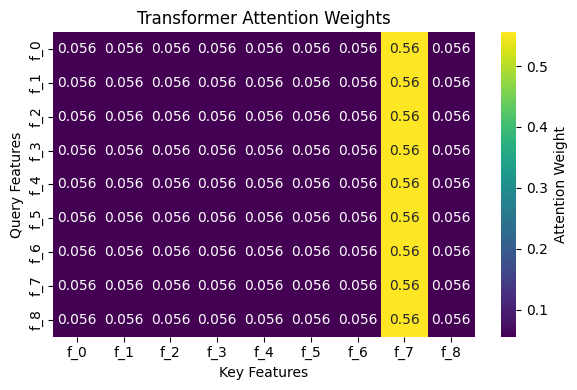

In [16]:
model.eval()  # Put the model in evaluation mode
with torch.no_grad():  # Disable gradient calculations
    attention_weights = model.get_attention_weights(features, context_embedding)

average_attention = torch.mean(torch.stack(attention_weights), dim=0)
single_batch_attention = average_attention[0].cpu().numpy()  # Single batch

# --- Create Feature Labels (IMPORTANT) ---
feature_names = [f"f_{i}" for i in range(single_batch_attention.shape[1])]  # Replace with YOUR feature names if available

# --- Visualize the Heatmap ---
plot_attention_heatmap(single_batch_attention, feature_names, figsize=(6, 4))